# Progetto d'esame di Data Analysis in Experimental Physics with Machine Learning
ciao
Gruppo composto dagli studenti Luca Attinà, Sharis Feriotto e Matteo Marchisio Caprioglio

Dataset ipotesi: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
Questo dataset non va bene perchè ha fatto data aug sul validation dataset, fallback al plant village originale: https://www.tensorflow.org/datasets/catalog/plant_village

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import os


In [2]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Load the PlantVillage dataset from TFDS instead of the new dataset (it performed data aug on the validation set, which is wrong)
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True,  # returns (image, label) pairs
    with_info=True
)


2025-07-17 15:44:02.798050: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-07-17 15:44:02.798073: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-07-17 15:44:02.798077: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2025-07-17 15:44:02.798101: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-17 15:44:02.798120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


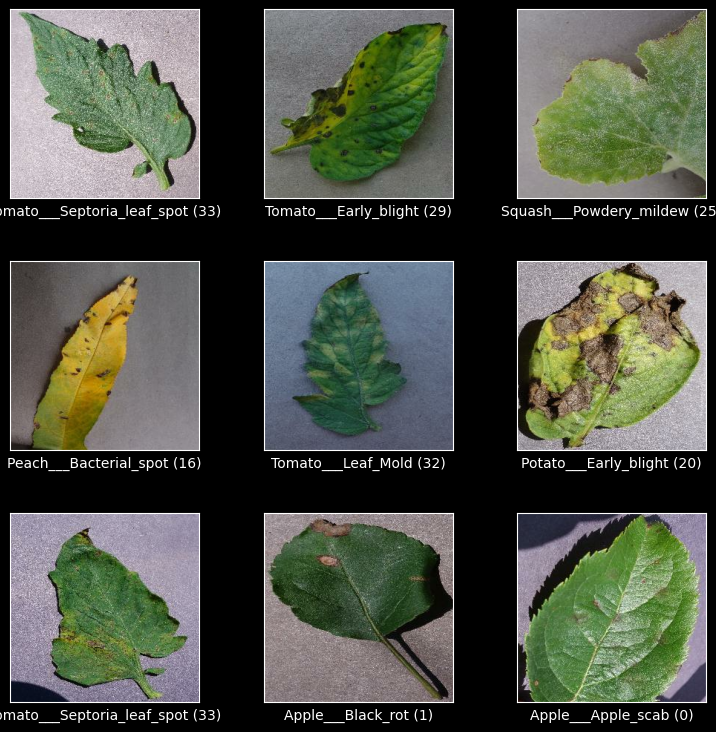

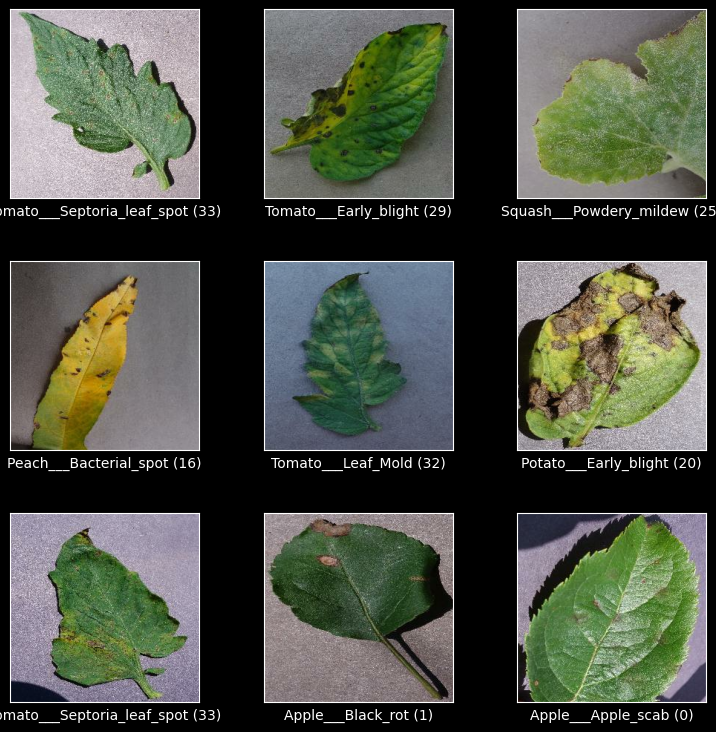

In [4]:
# Show example from the dataset
tfds.show_examples(ds_train, ds_info)


In [5]:
# useful constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
APPLY_DATA_AUGMENTATION = False
N_EPOCHS = 30


In [6]:
data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.RandomFlip("horizontal"),
    # tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, ds_info.features['label'].num_classes)

def preprocess_with_aug(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = data_augmentation(image)  # <-- augment here
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, ds_info.features['label'].num_classes)



In [7]:
# Preprocess and batch the datasets
if APPLY_DATA_AUGMENTATION:
    print("Data augmentation is enabled.")
    train_ds = ds_train.map(preprocess_with_aug).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset with data augmentation
else:
    print("Data augmentation is disabled.")
    train_ds = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset without data augmentation

val_ds = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Data augmentation is disabled.


In [8]:
class_names = ds_info.features['label'].names
print(class_names)


['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___

In [9]:
from keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, ReLU, Rescaling
from keras.optimizers.legacy import Adam, SGD
from keras.losses import CategoricalCrossentropy

from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [10]:
def simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=38):
    model = Sequential([
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(16, (5, 5), activation='relu', padding='same'),
        Dropout(0.2),
        MaxPooling2D((2, 2)),
        Conv2D(32, (5, 5), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [11]:
model = simple_cnn()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      1216      
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                 

In [12]:
optimizer = Adam(learning_rate=0.0002)
# optimizer = SGD(learning_rate=0.05, momentum=0.9)
model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the model
if APPLY_DATA_AUGMENTATION:
    check_point_filename = 'best_model_w_augmentation.h5'
else:
    check_point_filename = 'best_model_wo_augmentation.h5'

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=N_EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(check_point_filename, monitor='val_loss', save_best_only=True),
        # ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]
)


Epoch 1/30


2025-07-17 15:44:03.570842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


679/679 [==============================] - 17s 25ms/step - loss: 3.0912 - accuracy: 0.1999 - val_loss: 2.6574 - val_accuracy: 0.3204
Epoch 2/30
  4/679 [..............................] - ETA: 16s - loss: 2.5906 - accuracy: 0.3008

/Users/2mc/miniconda3/envs/daml/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


679/679 [==============================] - 17s 25ms/step - loss: 2.2689 - accuracy: 0.3811 - val_loss: 2.1146 - val_accuracy: 0.4294
Epoch 3/30
679/679 [==============================] - 17s 24ms/step - loss: 1.9031 - accuracy: 0.4667 - val_loss: 1.8838 - val_accuracy: 0.4846
Epoch 4/30
679/679 [==============================] - 17s 25ms/step - loss: 1.6956 - accuracy: 0.5207 - val_loss: 1.7230 - val_accuracy: 0.5196
Epoch 5/30
679/679 [==============================] - 17s 25ms/step - loss: 1.5458 - accuracy: 0.5588 - val_loss: 1.5966 - val_accuracy: 0.5528
Epoch 6/30
679/679 [==============================] - 17s 25ms/step - loss: 1.4380 - accuracy: 0.5883 - val_loss: 1.4899 - val_accuracy: 0.5782
Epoch 7/30
679/679 [==============================] - 17s 26ms/step - loss: 1.3560 - accuracy: 0.6102 - val_loss: 1.4209 - val_accuracy: 0.5992
Epoch 8/30
679/679 [==============================] - 17s 25ms/step - loss: 1.2959 - accuracy: 0.6273 - val_loss: 1.3459 - val_accuracy: 0.6163
Epo

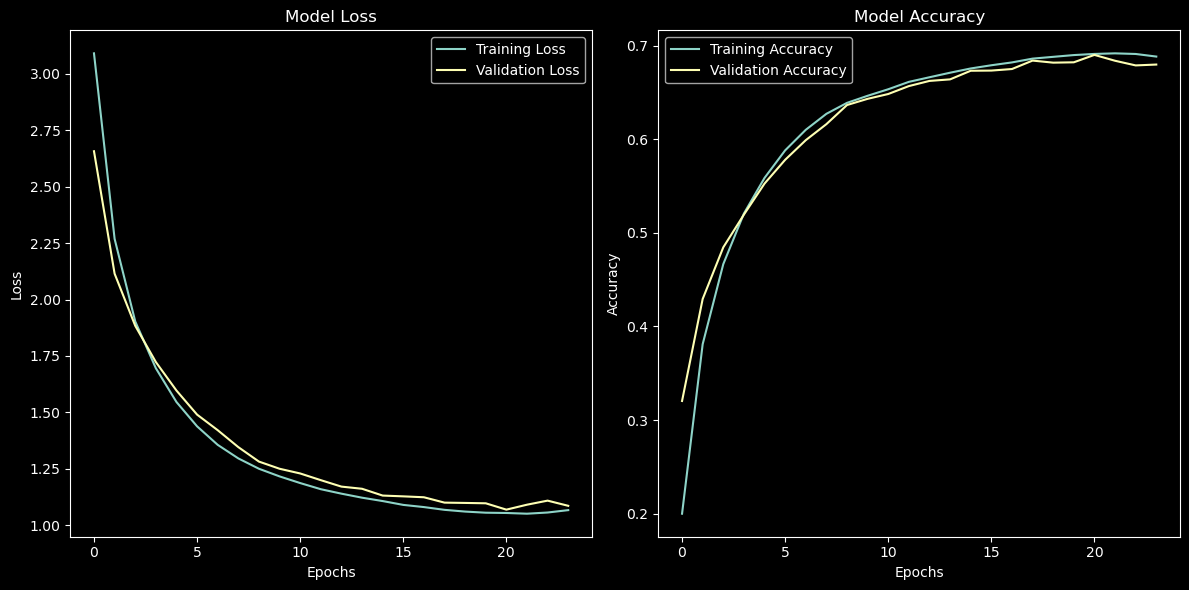

In [18]:
# plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# Plot ROC AUC for each class (one-vs-rest)
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get true labels and predicted probabilities for the test set
y_true = []
y_score = []

for images, labels in test_ds:
    y_true.append(labels.numpy())
    y_score.append(model.predict(images))

y_true = np.concatenate(y_true)
y_score = np.concatenate(y_score)

# Compute ROC AUC for each class
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_score[:, i])


2/2 [==============================] - 0s 5ms/step


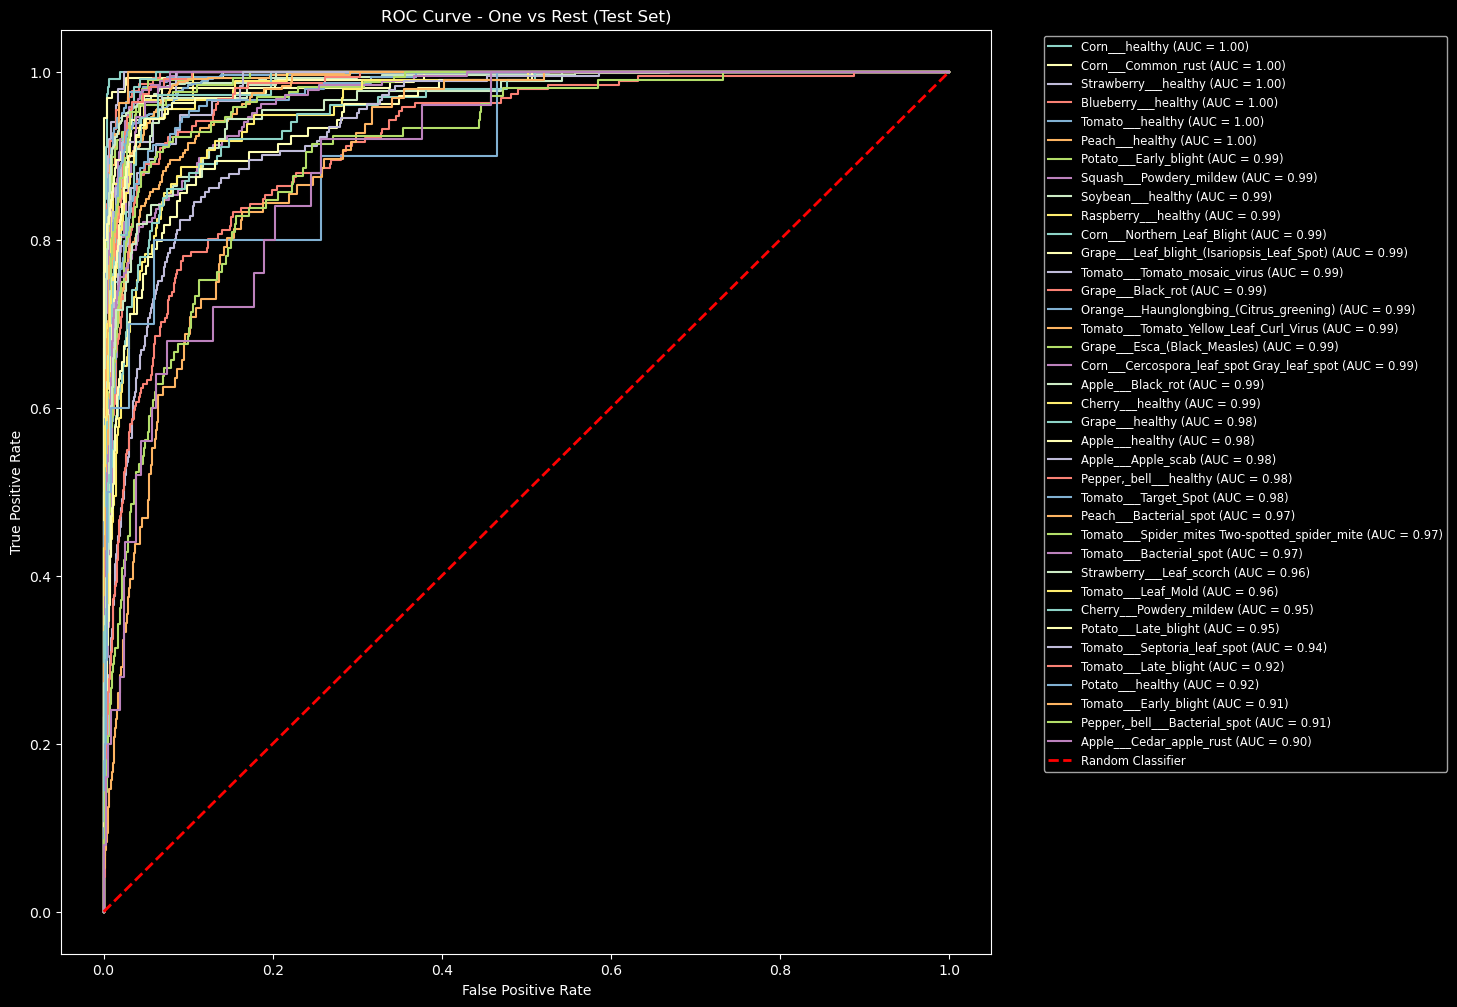

In [20]:
# Plot ROC curve for each class, legend sorted by AUC score
plt.figure(figsize=(12, 12))

# Prepare list of (auc, i) and sort descending
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)

for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')


In [21]:
# Plot confusion matrix for the test set
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true and predicted labels for the test set
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')


2/2 [==============================] - 0s 6ms/step


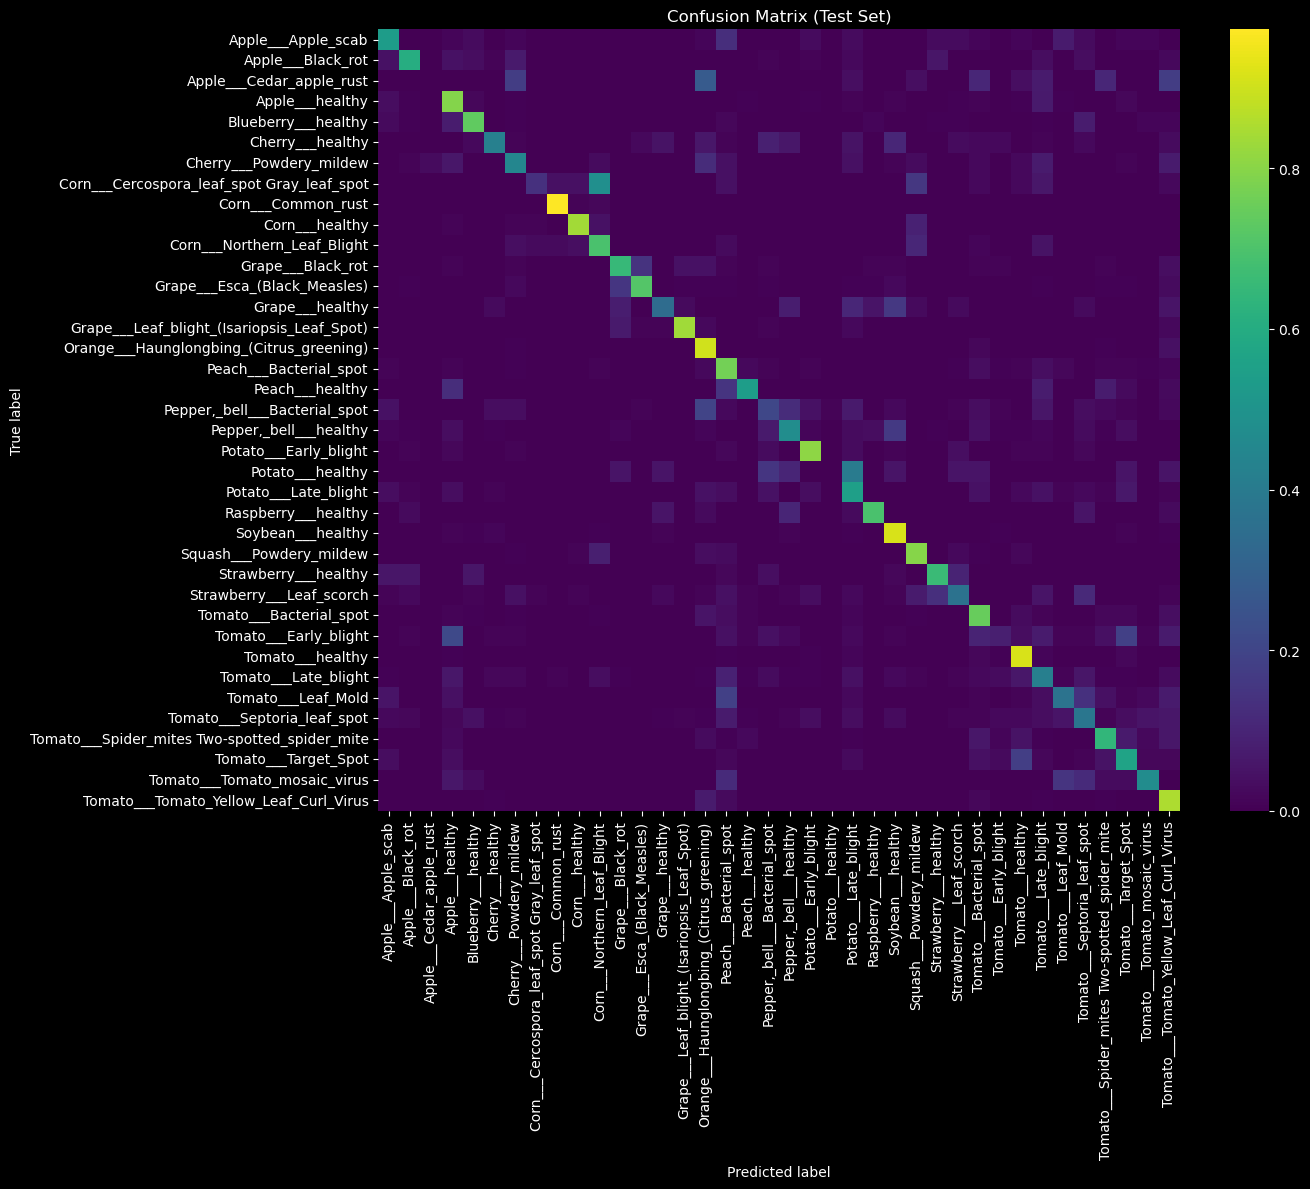

In [22]:
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='viridis', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Load the best model